In [1]:
import cobra
from cobra.io import load_json_model, save_json_model
from cobra import Model, Reaction, Metabolite
import numpy as np
from math import exp
import pandas as pd
from matplotlib import pyplot as plt
from fba_functions import *
import seaborn as sns
from scipy import stats
import pickle
from sklearn.metrics import r2_score

In [2]:
def load_pickle(filename):
    temp = None
    with open(filename,'rb') as f:
        temp = pickle.load(f)
    return temp
def dump_pickle(file, filename):
    with open(filename, 'wb') as f:
        pickle.dump( file , f)

In [3]:
ipsc_core = load_json_model('../data/gems/iPSC_core.json')
Adata = pd.read_csv('../data/gems/EnzymeActivity.csv')
A_dict = {Adata['Rxn'][i]:Adata['Activity(mmol/hr/g)'][i] for i in range(len(Adata.index))}
def get_grs(biomass, time_pts):
    output = []
    for i in range(len(biomass)-1):
        output.append( np.log(biomass[i+1]/biomass[i]) /(time_pts[i+1]-time_pts[i]) )
    return output  
def avg_cons(cons):
    output = []
    for i in range(len(cons)-1):
        output.append( (cons[i+1]+cons[i])/2 )
    return output
def norm_rates(biomass, cons, time_pts):
    output = []
    for i in range(len(biomass)-1):
        output.append( ((cons[i+1]-cons[i])/(biomass[i]/2+biomass[i+1]/2) )/(time_pts[i+1]-time_pts[i]) )
    return output
def get_pcc(x,y):
    coeff, pv = stats.pearsonr( x, y)
    return coeff

In [4]:
data_low=pd.read_csv('../data/exp_data/CultureData_lowNH4.csv')
data_low=data_low.rename(columns={'Biomass_avg(g/L)':'Biomass_avg','Biomass_std(g/L)':'Biomass_std'})
data_high=pd.read_csv('../data/exp_data/CultureData_highNH4.csv')
data_high=data_high.rename(columns={'Biomass_avg(g/L)':'Biomass_avg','Biomass_std(g/L)':'Biomass_std'})
mets=['Glucose','Gln','Lac','NH4']
Ts= [data_low.Time[i]/2+data_low.Time[i+1]/2 for i in range(len(data_low.Time)-1)]
grs=get_grs(data_low.Biomass_avg, data_low.Time)
approx_low = pd.DataFrame(zip(Ts,grs),columns=['Time','gr'])
for met in mets:
    approx_low[met+'_rate']=norm_rates( data_low.Biomass_avg, data_low[met+'_avg'], data_low.Time)
    approx_low[met+'_conc']=avg_cons( data_low[met+'_avg'] )
Ts=[data_high.Time[i]/2+data_high.Time[i+1]/2 for i in range(len(data_high.Time)-1)]
grs=get_grs(data_high.Biomass_avg, data_high.Time)
approx_high = pd.DataFrame(zip(Ts,grs),columns=['Time','gr'])
for met in mets:
    approx_high[met+'_rate']=norm_rates( data_high.Biomass_avg, data_high[met+'_avg'], data_high.Time)
    approx_high[met+'_conc']=avg_cons( data_high[met+'_avg'] )

# 1. Low initial NH4+

In [5]:
ptot = 0.67366; NGAM = 2.2771;T=60;#start from T=42hr
ic_lowN={'BIOMASS':0.155,'nh4_e':2.320,'lac__L_e':9.233,'glc__D_e':11.567,'gln__L_e':3.333}
Dr=0.01

In [6]:
# met_profile_lowN, flux_profile_lowN = dpcfba(ipsc_core, ptot, NGAM, Dr, A_dict, ic_lowN, T)
# met_profile_lowN['T'] = [t+42 for t in met_profile_lowN['T']]

In [7]:
# dump_pickle(met_profile_lowN, '../data/simulation_results/met_profile_lowN.pkl')
# dump_pickle(flux_profile_lowN, '../data/simulation_results/flux_profile_lowN.pkl')

In [5]:
met_profile_lowN=load_pickle('../data/simulation_results/met_profile_lowN.pkl')
flux_profile_lowN=load_pickle('../data/simulation_results/flux_profile_lowN.pkl')

In [6]:
items = ['BIOMASS','glc__D_e', 'gln__L_e','lac__L_e','nh4_e']
temp_pd = data_low.iloc[2:]
for i in range(5):
    exp_values = list(temp_pd.iloc[:,i*2+3])
    pred_values = [ met_profile_lowN[items[i]][T-42] for T in list(temp_pd['Time'])]
    print(get_pcc(exp_values,pred_values))   

0.9719581268317192
0.9600773602102671
0.9125568003623581
0.9372495154070665
0.9912838359258873


In [7]:
items = ['BIOMASS','glc__D_e', 'gln__L_e','lac__L_e','nh4_e']
temp_pd = data_low.iloc[2:]
for i in range(5):
    exp_values = list(temp_pd.iloc[:,i*2+3])
    pred_values = [ met_profile_lowN[items[i]][T-42] for T in list(temp_pd['Time'])]
    print(r2_score(exp_values,pred_values))   

0.6981421039526021
0.7171847644156272
-0.8572057757333269
0.42409913937630683
0.5754873349887577


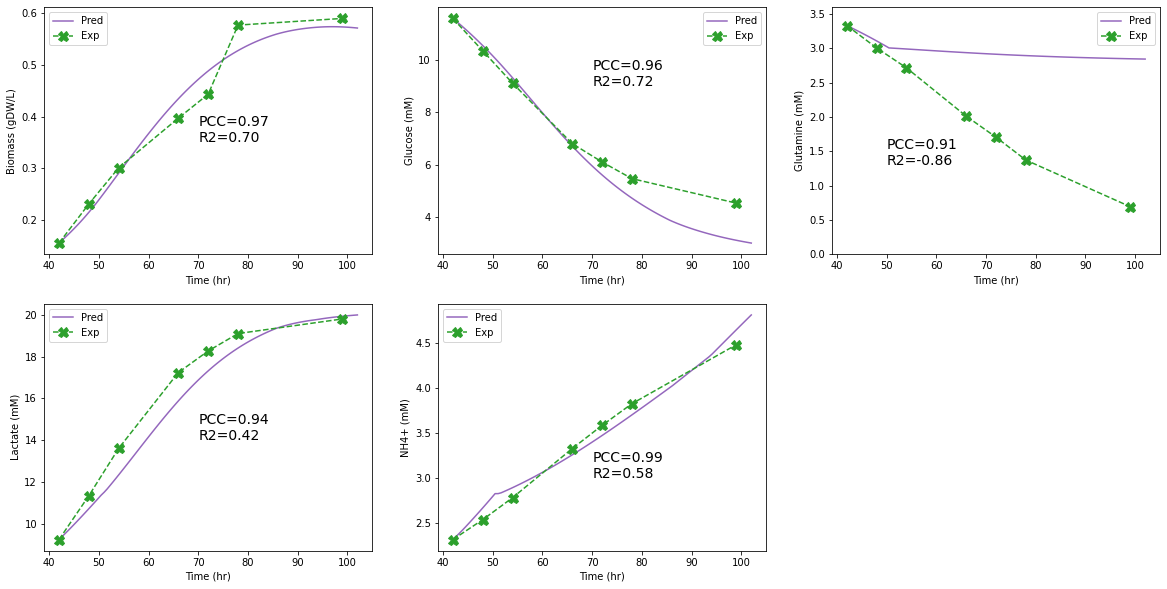

In [9]:
items = ['BIOMASS','glc__D_e', 'gln__L_e','lac__L_e','nh4_e']
fig, axs = plt.subplots(2,3,figsize=(20,10))
temp_pd = data_low.iloc[2:]
for i in range(5):
    x,y=int(i/3),int(i%3)
    axs[x][y].plot(met_profile_lowN['T'],met_profile_lowN[items[i]],color='tab:purple',label='Pred')
    axs[x][y].plot(list(temp_pd['Time']), list(temp_pd.iloc[:,i*2+3]),marker='X',markersize=10,
                   ls='--',color='tab:green',label='Exp' )
    axs[x][y].legend()
    axs[x][y].set_xlabel('Time (hr)')
axs[0][0].set_ylabel('Biomass (gDW/L)')
axs[0][1].set_ylabel('Glucose (mM)')
axs[0][2].set_ylabel('Glutamine (mM)')
axs[1][0].set_ylabel('Lactate (mM)')
axs[1][1].set_ylabel('NH4+ (mM)')

# axs[0][1].set_ylim([0,12.5])
axs[0][2].set_ylim([0,3.6])
axs[0][0].text(70,0.35,s='PCC=0.97\nR2=0.70',fontsize=14)
axs[0][1].text(70,9,s='PCC=0.96\nR2=0.72',fontsize=14)
axs[0][2].text(50,1.3,s='PCC=0.91\nR2=-0.86',fontsize=14)
axs[1][0].text(70,14,s='PCC=0.94\nR2=0.42',fontsize=14)
axs[1][1].text(70,3,s='PCC=0.99\nR2=0.58',fontsize=14)
axs[1][2].set_axis_off()
# plt.savefig('../../Figures/dFBA_lowN.svg',format='svg',dpi=150)

# 2. High initial NH4+

In [13]:
ptot = 0.67366; NGAM = 2.2771;T=70; #start from T=30hr
ic_highN={'BIOMASS':0.047,'nh4_e':4.23,'lac__L_e':2.533,'glc__D_e':15.133,'gln__L_e':4.753}
Dr=0.01

In [14]:
# met_profile_highN, flux_profile_highN = dpcfba(ipsc_core, ptot, NGAM, Dr, A_dict, ic_highN, T)
# met_profile_highN['T'] = [t+30 for t in met_profile_highN['T']]

In [15]:
# dump_pickle(met_profile_highN, '../data/simulation_results/met_profile_highN.pkl')
# dump_pickle(flux_profile_highN, '../data/simulation_results/flux_profile_highN.pkl')

In [10]:
met_profile_highN=load_pickle('../data/simulation_results/met_profile_highN.pkl')
flux_profile_highN=load_pickle('../data/simulation_results/flux_profile_highN.pkl')

In [17]:
items = ['BIOMASS','glc__D_e', 'gln__L_e','lac__L_e','nh4_e']
temp_pd = data_high.iloc[1:]
for i in range(5):
    exp_values = list(temp_pd.iloc[:,i*2+3])
    pred_values = [ met_profile_highN[items[i]][T-30] for T in list(temp_pd['Time'])]
    print(get_pcc(exp_values,pred_values))   

0.9640634285390504
0.9653761649592506
0.9711625939807031
0.9879744910792162
0.9918097007199393


In [18]:
items = ['BIOMASS','glc__D_e', 'gln__L_e','lac__L_e','nh4_e']
temp_pd = data_high.iloc[1:]
for i in range(5):
    exp_values = list(temp_pd.iloc[:,i*2+3])
    pred_values = [ met_profile_highN[items[i]][T-30] for T in list(temp_pd['Time'])]
    print(r2_score(exp_values,pred_values)) 

0.8824440551926261
0.7382831439188706
0.6397188256493147
-0.029382742051222932
0.9834170694677601


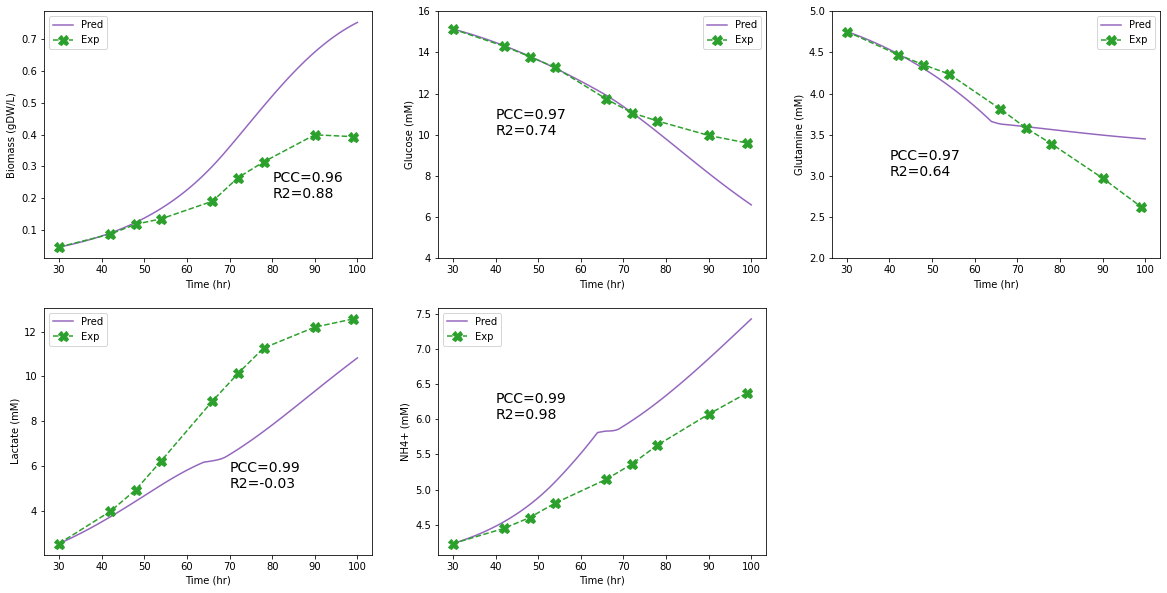

In [11]:
items = ['BIOMASS','glc__D_e', 'gln__L_e','lac__L_e','nh4_e']
fig, axs = plt.subplots(2,3,figsize=(20,10))
temp_pd = data_high.iloc[1:]
for i in range(5):
    x,y=int(i/3),int(i%3)
    axs[x][y].plot(met_profile_highN['T'],met_profile_highN[items[i]],color='tab:purple',label='Pred')
    axs[x][y].plot(list(temp_pd['Time']), list(temp_pd.iloc[:,i*2+3]),marker='X',markersize=10,
                   ls='--',color='tab:green',label='Exp' )
    axs[x][y].legend()
    axs[x][y].set_xlabel('Time (hr)')

axs[0][0].set_ylabel('Biomass (gDW/L)')
axs[0][1].set_ylabel('Glucose (mM)')
axs[0][2].set_ylabel('Glutamine (mM)')
axs[1][0].set_ylabel('Lactate (mM)')
axs[1][1].set_ylabel('NH4+ (mM)')

axs[0][1].set_ylim([4,16])
axs[0][2].set_ylim([2.0,5])
axs[0][0].text(80,0.2,s='PCC=0.96\nR2=0.88',fontsize=14)
axs[0][1].text(40,10,s='PCC=0.97\nR2=0.74',fontsize=14)
axs[0][2].text(40,3,s='PCC=0.97\nR2=0.64',fontsize=14)
axs[1][0].text(70,5,s='PCC=0.99\nR2=-0.03',fontsize=14)
axs[1][1].text(40,6,s='PCC=0.99\nR2=0.98',fontsize=14)
axs[1][2].set_axis_off()
# plt.savefig('../../Figures/dFBA_highN.svg',format='svg',dpi=150)